<a href="https://colab.research.google.com/github/MinhPhanBabsonMSBA/Stock-analysis-/blob/main/Copy_of_LSTM_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.2292 - val_loss: 0.0153
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1272 - val_loss: 0.0055
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0549 - val_loss: 0.0048
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0322 - val_loss: 0.0095
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0244 - val_loss: 0.0153
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0209 - val_loss: 0.0188
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0170 - val_loss: 0.0192
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0172 - val_loss: 0.0171
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0140 - val_loss: 0.0147
Epoch 10/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0151 - val_loss: 0.0122
Epoch 11/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0126 - val_loss: 0.0108
Epoch 12/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0145 - val_loss: 0.0097
Epoch 13/20


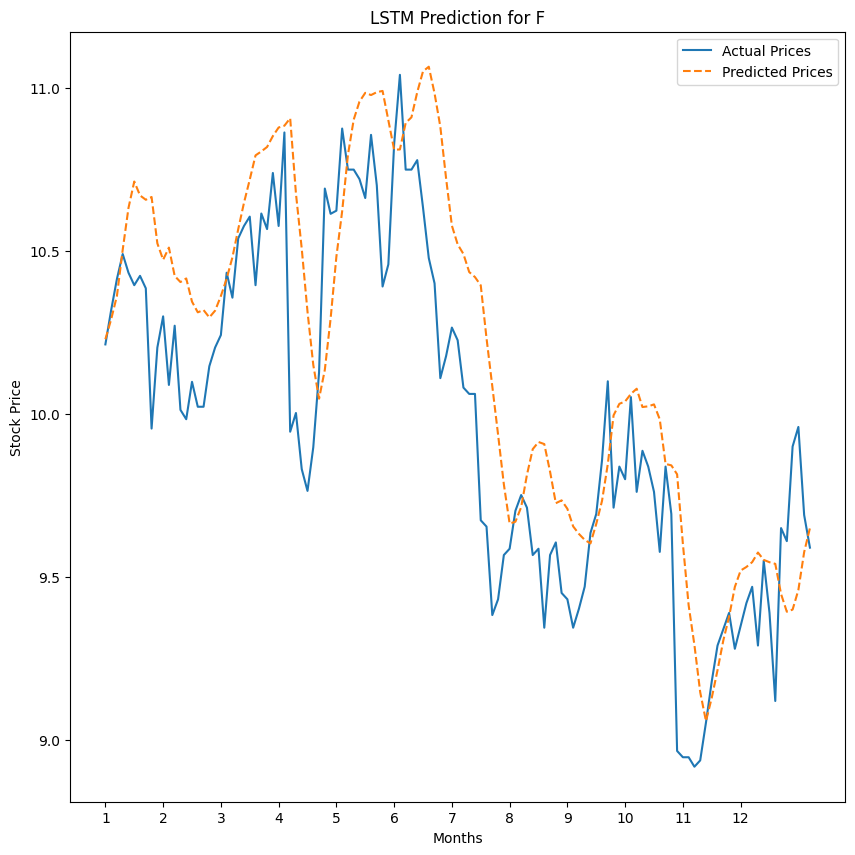

In [11]:

# Load stock data
ticker = "GS"  # Goldman Sachs example
stock = yf.Ticker(ticker)
df = stock.history(period="1y")  # Fetch last 1 year of data

# Use multiple predictors: 'Close', 'Open', 'Volume', 'High', and 'Low'
df = df[['Close', 'Open', 'Volume', 'High', 'Low']]

# Scale the data: Scaling all features together; note that volume and price may be on very different scales.
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)

# Prepare the dataset for LSTM with multiple predictors
def prepare_data(data, look_back=5):
    X, y = [], []
    for i in range(look_back, len(data)):
        # Use all features in the window (each sample is a matrix of shape (look_back, num_features))
        X.append(data[i-look_back:i, :])
        # Use the first feature ('Close') as the target variable
        y.append(data[i, 0])
    X, y = np.array(X), np.array(y)
    return X, y

look_back = 5  # Number of days to use for each input sequence
X, y = prepare_data(df_scaled, look_back)

# Split data into training and test sets (50% for training)
train_size = int(len(X) * 0.5)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Determine the number of features (should be 5: Close, Open, Volume, High, Low)
num_features = df_scaled.shape[1]

# Build LSTM model with updated input shape
model = Sequential([
    LSTM(units=10, return_sequences=False, input_shape=(look_back, num_features)),
    Dense(units=1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with specified epochs and batch size
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

# Make predictions
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values for the 'Close' price.
# Since our scaler was fit on all features, and we only want to invert the 'Close' column,
# we need to reconstruct an array of the same shape.
def inverse_transform_feature(scaled_values, scaler, feature_index=0):
    # Create an array of zeros with the same number of columns as the original data.
    dummy = np.zeros((scaled_values.shape[0], scaler.scale_.shape[0]))
    # Insert the scaled values into the column corresponding to the target feature (e.g., 'Close' is index 0).
    dummy[:, feature_index] = scaled_values[:, 0]
    # Inverse transform the data
    inv = scaler.inverse_transform(dummy)
    # Return the target feature column.
    return inv[:, feature_index].reshape(-1, 1)

y_pred = inverse_transform_feature(y_pred, scaler, feature_index=0)
y_test = inverse_transform_feature(y_test.reshape(-1, 1), scaler, feature_index=0)

# Plot results with corrected month labeling (assuming 12 months over your test set)
months = 12
points_per_month = len(y_test) // months
tick_positions = [i * points_per_month for i in range(months)]
tick_labels = [i+1 for i in range(months)]

plt.figure(figsize=(10,10))
plt.plot(y_test, label='Actual Prices')
plt.plot(y_pred, label='Predicted Prices', linestyle='dashed')
plt.legend()
plt.title(f"LSTM Prediction for {ticker}")
plt.xlabel("Months")
plt.ylabel("Stock Price")
plt.xticks(tick_positions, tick_labels)
plt.show()

In [12]:
from sklearn.metrics import r2_score
import numpy as np

# Assuming y_test and y_pred are your actual and predicted prices (as numpy arrays)
# Compute the R² score
r2 = r2_score(y_test, y_pred)
print("R² Score:", r2)

# Compute the Mean Absolute Percentage Error (MAPE)
def MAPE(y_true, y_pred):
    # Adding a small value (epsilon) to avoid division by zero if needed
    epsilon = 1e-10
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

mape = MAPE(y_test, y_pred)
accuracy_rate = 100 - mape

print("MAPE: {:.2f}%".format(mape))
print("Accuracy Rate (100 - MAPE): {:.2f}%".format(accuracy_rate))

R² Score: 0.5787684842239531
MAPE: 2.69%
Accuracy Rate (100 - MAPE): 97.31%


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0258 - val_loss: 0.1717
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0137 - val_loss: 0.1209
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0076 - val_loss: 0.0837
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0037 - val_loss: 0.0610
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0035 - val_loss: 0.0511
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0037 - val_loss: 0.0505
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0039 - val_loss: 0.0527
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0030 - val_loss: 0.0540
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0029 - val_loss: 0.0509
Epoch 10/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0031 - val_loss: 0.0466
Epoch 11/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0025 - val_loss: 0.0425
Epoch 12/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0028 - val_loss: 0.0400
Epoch 13/20


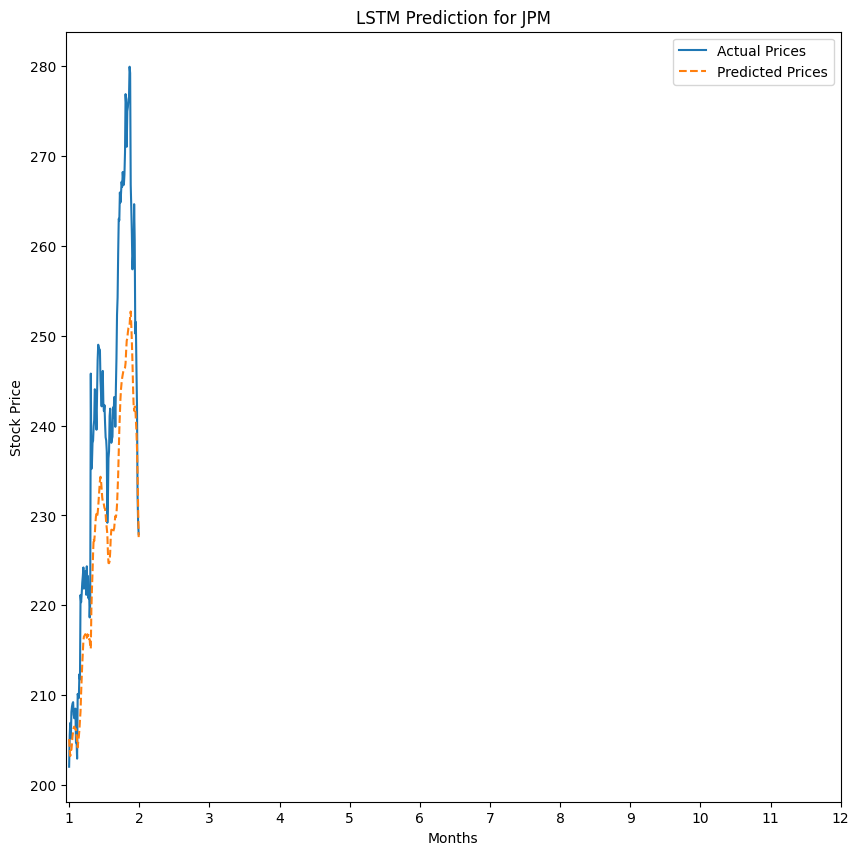

In [13]:
# Load stock data
ticker = "JPM"
stock = yf.Ticker(ticker)
df = stock.history(period="1y")  # Fetch last 1 year of data to reduce memory usage

# Use the closing price for prediction
df = df[['Close']]

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)

# Prepare the dataset for LSTM
def prepare_data(data, look_back=5):  # Reduce look_back to lower memory usage
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i, 0])
        y.append(data[i, 0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y

look_back = 5  # Use fewer days to reduce dataset size
X, y = prepare_data(df_scaled, look_back)

# Split data into training and test sets


train_size = int(len(X) * 0.5)  # Reduce training size to 50%
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


# Build LSTM model with fewer units to optimize memory
model = Sequential([
    LSTM(units=10, return_sequences= False, input_shape=(look_back, 1)),
    Dense(units=1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with fewer epochs and a smaller batch size
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

# Make predictions
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot results
months = 12
points_per_month = len(y_test)

tick_positions = [i * points_per_month for i in range(months)]
tick_labels = [i+1 for i in range(months)]

plt.figure(figsize=(10,10))
plt.plot(y_test, label='Actual Prices')
plt.plot(y_pred, label='Predicted Prices', linestyle='dashed')
plt.legend()
plt.title(f"LSTM Prediction for {ticker}")
plt.xlabel("Months")
plt.ylabel("Stock Price")

plt.xticks(tick_positions, tick_labels)
plt.show()

In [14]:
from sklearn.metrics import r2_score
import numpy as np

# Assuming y_test and y_pred are your actual and predicted prices (as numpy arrays)
# Compute the R² score
r2 = r2_score(y_test, y_pred)
print("R² Score:", r2)

# Compute the Mean Absolute Percentage Error (MAPE)
def MAPE(y_true, y_pred):
    # Adding a small value (epsilon) to avoid division by zero if needed
    epsilon = 1e-10
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

mape = MAPE(y_test, y_pred)
accuracy_rate = 100 - mape  # interpreted as "accuracy" percentage

print("MAPE: {:.2f}%".format(mape))
print("Accuracy Rate (100 - MAPE): {:.2f}%".format(accuracy_rate))

R² Score: 0.5183331503356299
MAPE: 4.90%
Accuracy Rate (100 - MAPE): 95.10%


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0443 - val_loss: 0.4056
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0325 - val_loss: 0.3454
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0233 - val_loss: 0.2909
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0136 - val_loss: 0.2411
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0085 - val_loss: 0.1958
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0052 - val_loss: 0.1568
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0041 - val_loss: 0.1281
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0035 - val_loss: 0.1124
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0031 - val_loss: 0.1091
Epoch 10/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0034 - val_loss: 0.1099
Epoch 11/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0036 - val_loss: 0.1110
Epoch 12/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0036 - val_loss: 0.1107
Epoch 13/20


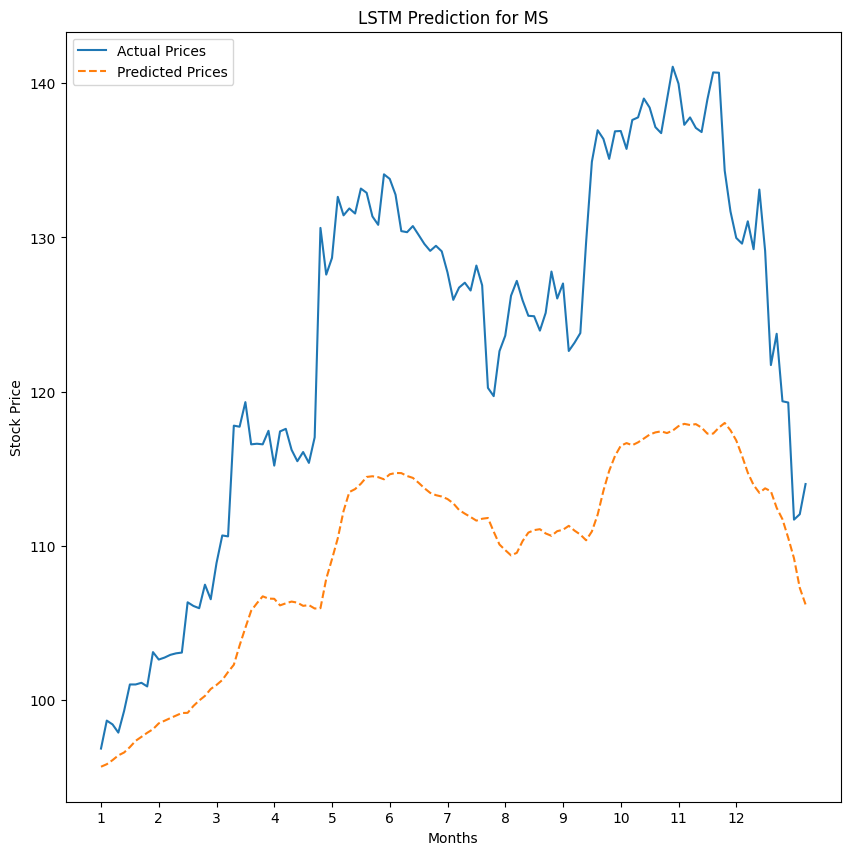

In [7]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load stock data
ticker = "MS"
stock = yf.Ticker(ticker)
df = stock.history(period="1y")  # Fetch last 1 year of data to reduce memory usage

# Use the closing price for prediction
df = df[['Close']]

# Scale the data
scaler = MinMaxScaler (feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)

# Prepare the dataset for LSTM
def prepare_data(data, look_back=5):  # Reduce look_back to lower memory usage
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i, 0])
        y.append(data[i, 0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y

look_back = 5  # Use fewer days to reduce dataset size
X, y = prepare_data(df_scaled, look_back)

# Split data into training and test sets


train_size = int(len(X) * 0.5)  # Reduce training size to 50%
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


# Build LSTM model with fewer units to optimize memory
model = Sequential([
    LSTM(units=10, return_sequences= False, input_shape=(look_back, 1)),
    Dense(units=1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with fewer epochs and a smaller batch size
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

# Make predictions
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot results
months = 12
points_per_month = len(y_test) // months
tick_positions = [i * points_per_month for i in range(months)]

tick_labels = [i+1 for i in range(months)]

plt.figure(figsize=(10,10))
plt.plot(y_test, label='Actual Prices')
plt.plot(y_pred, label='Predicted Prices', linestyle='dashed')
plt.legend()
plt.title(f"LSTM Prediction for {ticker}")
plt.xlabel("Months")
plt.ylabel("Stock Price")

plt.xticks(tick_positions, tick_labels)
plt.show()

In [15]:
import streamlit as st
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import r2_score

# Helper function to compute MAPE
def MAPE(y_true, y_pred):
    epsilon = 1e-10  # avoid division by zero
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

# Helper function to inverse transform only the target feature (Close price)
def inverse_transform_feature(scaled_values, scaler, feature_index=0):
    # Create an array of zeros with the same number of columns as the original data.
    dummy = np.zeros((scaled_values.shape[0], scaler.scale_.shape[0]))
    # Insert the scaled values into the target feature column
    dummy[:, feature_index] = scaled_values[:, 0]
    inv = scaler.inverse_transform(dummy)
    return inv[:, feature_index].reshape(-1, 1)

# Data preparation function for multiple predictors
def prepare_data(data, look_back=5):
    X, y = [], []
    for i in range(look_back, len(data)):
        # Use all features for the input sequence
        X.append(data[i-look_back:i, :])
        # Use the first feature ('Close') as the target variable
        y.append(data[i, 0])
    X, y = np.array(X), np.array(y)
    return X, y

st.title("Stock Price Prediction with LSTM")
st.write("Enter a stock ticker to view the LSTM prediction plot and performance metrics.")

# User input for stock ticker
ticker = st.text_input("Stock Ticker", "GS")  # Default ticker: GS

if st.button("Predict"):
    st.write(f"Fetching data for {ticker} ...")
    stock = yf.Ticker(ticker)
    df = stock.history(period="1y")  # 1 year of historical data

    if df.empty:
        st.error("No data found for the ticker. Please try another ticker.")
    else:
        # Use multiple predictors: 'Close', 'Open', 'Volume', 'High', and 'Low'
        df = df[['Close', 'Open', 'Volume', 'High', 'Low']]

        # Scale the data (all features together)
        scaler = MinMaxScaler(feature_range=(0, 1))
        df_scaled = scaler.fit_transform(df)

        # Prepare dataset for LSTM
        look_back = 5  # Number of days to use as input sequence
        X, y = prepare_data(df_scaled, look_back)

        # Split data into training and testing sets (50% each)
        train_size = int(len(X) * 0.5)
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]

        num_features = df_scaled.shape[1]  # Should be 5

        # Build a simple LSTM model
        model = Sequential([
            LSTM(units=10, return_sequences=False, input_shape=(look_back, num_features)),
            Dense(units=1)
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')

        st.write("Training the LSTM model...")
        model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test), verbose=0)

        # Make predictions on the test set
        y_pred = model.predict(X_test)

        # Inverse transform predictions and actual y-values (for the 'Close' price)
        y_pred = inverse_transform_feature(y_pred, scaler, feature_index=0)
        y_test = inverse_transform_feature(y_test.reshape(-1, 1), scaler, feature_index=0)

        # Compute performance metrics
        r2 = r2_score(y_test, y_pred)
        mape = MAPE(y_test, y_pred)
        accuracy_rate = 100 - mape  # A rough interpretation

        st.write("### Performance Metrics")
        st.write(f"**R² Score:** {r2:.3f}")
        st.write(f"**MAPE:** {mape:.2f}%")
        st.write(f"**Accuracy Rate (100 - MAPE):** {accuracy_rate:.2f}%")

        # Plot results
        # Assume 12 months of data for the test set for tick labeling purposes
        months = 12
        points_per_month = len(y_test) // months if len(y_test) >= months else 1
        tick_positions = [i * points_per_month for i in range(months)]
        tick_labels = [i+1 for i in range(months)]

        fig, ax = plt.subplots(figsize=(10, 10))
        ax.plot(y_test, label='Actual Prices')
        ax.plot(y_pred, label='Predicted Prices', linestyle='dashed')
        ax.set_title(f"LSTM Prediction for {ticker}")
        ax.set_xlabel("Months")
        ax.set_ylabel("Stock Price")
        ax.set_xticks(tick_positions)
        ax.set_xticklabels(tick_labels)
        ax.legend()

        st.pyplot(fig)

ModuleNotFoundError: No module named 'streamlit'